## Truncated SVD with data not centered
### Contrary to the other notebook 'SVD Grid Search', the data (the movies rate) is not centered before fitting the truncated SVD. Such a model has poorer mathematical performance (see below RMSE and MAE results on test data) but the recommendations based on the embedding calculated appear to be more relevant. Hence, this model has been deployed in the app.

### 1. Importation of librairies
### 2. Import and process data
### 3. Fitting and export the model

## 1. Importation of useful librairies

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import pickle

from scipy.sparse import csr_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD, NMF

## 2. Retrieve data and preprocess it

### a. Let's retrieve our dataset

In [2]:
# data contains ratings of movie by users (over 27 M ratings)
data = pd.read_csv('../data/MovieLens/ml-latest/ratings.csv', usecols=['userId','movieId','rating'])
data = data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 635.2 MB


In [3]:
print('the dataset contains {:,} movies rated by {:,} users.'.format(
    len(data['movieId'].unique()),len(data['userId'].unique())))

the dataset contains 53,889 movies rated by 283,228 users.


In [4]:
data.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


### b. Filter data according to the number of ratings per movie and per user.

In [5]:
# Count ratings per movie
count_ratings_per_movie = data[['movieId','rating']].groupby('movieId').count().reset_index(drop=False).\
                                                    rename(columns={'rating':'number_of_ratings_per_movie'})
count_ratings_per_movie.head()

,movieId,number_of_ratings_per_movie
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474


In [6]:
# Count ratings per movie
count_ratings_per_user = data[['userId','rating']].groupby('userId').count().reset_index(drop=False).\
                                                    rename(columns={'rating':'number_of_ratings_per_user'})
count_ratings_per_user.head()

,userId,number_of_ratings_per_user
0,1,16
1,2,15
2,3,11
3,4,736
4,5,72


In [7]:
data = pd.merge(data, count_ratings_per_movie, on='movieId')
data = pd.merge(data, count_ratings_per_user, on='userId')
data.head()

,userId,movieId,rating,number_of_ratings_per_movie,number_of_ratings_per_user
0,1,307,3.5,7958,16
1,1,481,3.5,6037,16
2,1,1091,1.5,6138,16
3,1,1257,4.5,5902,16
4,1,1449,4.5,6867,16


In [8]:
# Sparse data is a major issue for matrix factorization. Thus, we decide to keep only movies and users
# with over 1,000 ratings.

In [9]:
data_1000 = data[(data['number_of_ratings_per_user'] >= 1000) & (data['number_of_ratings_per_movie'] >= 1000)]
data_1000 = data_1000.dropna().reset_index(drop=True).drop(['number_of_ratings_per_movie','number_of_ratings_per_user'],axis=1)
data_1000.head()

,userId,movieId,rating
0,214,307,4.0
1,214,481,3.0
2,214,1590,3.0
3,214,2986,2.0
4,214,3020,4.0


### c. Prepare data

#### It's necessary to transform our data into sparse matrix. In order to avoid creating rows/columns with only zeros, we replace the actual user and movies ids by 'id_model' designed on purpose to go from 0 to the number of user/movies.

In [10]:
movieId_model = pd.DataFrame(data_1000['movieId'].unique()).reset_index(drop=False)
movieId_model = movieId_model.rename(columns={'index':'movieId_model',0:'movieId'})
movieId_model.head()

,movieId_model,movieId
0,0,307
1,1,481
2,2,1590
3,3,2986
4,4,3020


In [11]:
userId_model = pd.DataFrame(data_1000['userId'].unique()).reset_index(drop=False)
userId_model = userId_model.rename(columns={'index':'userId_model',0:'userId'})
userId_model.head()

,userId_model,userId
0,0,214
1,1,239
2,2,719
3,3,1933
4,4,2025


In [12]:
data_1000 = pd.merge(data_1000, movieId_model, on='movieId')
data_1000 = pd.merge(data_1000, userId_model, on='userId')
data_1000.head()

,userId,movieId,rating,movieId_model,userId_model
0,214,307,4.0,0,0
1,214,481,3.0,1,0
2,214,1590,3.0,2,0
3,214,2986,2.0,3,0
4,214,3020,4.0,4,0


In [13]:
total_users = len(data_1000['userId_model'].unique())
total_movies =  len(data_1000['movieId_model'].unique())

print('For information, the matrix is meant to contain {:,} rows (sample or user) \
and {:,} columns (item or movies) with {:.0%} of filled data.'.\
      format(total_users,
             total_movies,
             data_1000.shape[0]/(total_users*total_movies)))

For information, the matrix is meant to contain 2,782 rows (sample or user) and 3,931 columns (item or movies) with 29% of filled data.


### d. Create train and test datasets

In [14]:
all_user_id = data_1000['userId_model'].unique()
random.shuffle(all_user_id)

In [15]:
train_size = int(0.80 * len(all_user_id))
train_user_id = all_user_id[:train_size]
test_user_id = list(set(all_user_id) - set(train_user_id))

In [16]:
data_train = pd.merge(pd.DataFrame(train_user_id, columns=['userId_model']),
                      data_1000,
                      on='userId_model')

data_test = pd.merge(pd.DataFrame(test_user_id, columns=['userId_model']),
                      data_1000,
                      on='userId_model')

In [17]:
# We need both dataset to have the same number of colons to be able to use the .transform of SVD/NMF.
print('cols for a sparse data_train', np.max(data_train['userId_model']))
print('cols for a sparse data_test', np.max(data_test['userId_model']))

cols for a sparse data_train 2781
cols for a sparse data_test 2774


In [18]:
# kind of a hack : we add one line to data test for userId_model = 2781
cols = data_test.columns
data_test = data_test.append(pd.DataFrame([2781,0,0,0,0],index=cols).T, ignore_index=True)

### e. Convert to sparse matrices

In [19]:
data_train_csr = csr_matrix((data_train['rating'],
                             (data_train['userId_model'], data_train['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_train_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 2531137 stored elements in Compressed Sparse Row format>

In [20]:
data_test_csr = csr_matrix((data_test['rating'],
                             (data_test['userId_model'], data_test['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_test_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 630601 stored elements in Compressed Sparse Row format>

In [21]:
data_1000_csr = csr_matrix((data_1000['rating'],
                             (data_1000['userId_model'], data_1000['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_1000_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 3161737 stored elements in Compressed Sparse Row format>

## 3. Truncated SVD : fitting and export the model

### Let's check the performances on train and test dataset.

In [77]:
%%time
# We perform a truncated SVD with 200 components as this parameter appeared to be a balanced choice between
# performance and readability of the model in the 'grid search' study realized in the notebook
# entitled 'SVD Grid Search'.
svd = TruncatedSVD(n_components=200, n_iter=10, random_state=0)
svd.fit(data_train_csr)

CPU times: user 19.8 s, sys: 4.42 s, total: 24.2 s
Wall time: 3.38 s


TruncatedSVD(n_components=200, n_iter=10, random_state=0)

In [28]:
train_predict_ratings = np.matmul(svd.transform(data_train_csr), svd.components_) # users/movies
test_predict_ratings = np.matmul(svd.transform(data_test_csr), svd.components_)   # users/movies

In [37]:
# let's calculate predictions on train and test data
train_predictions = []
test_predictions = []

for k in range(data_train.shape[0]):
    i = data_train.iloc[k,0] # userId_model
    j = data_train.iloc[k,4] # movieId_model
    train_predictions.append(train_predict_ratings[i,j])

for k in range(data_test.shape[0]):
    i = data_test.iloc[k,0] # userId_model
    j = data_test.iloc[k,4] # movieId_model
    test_predictions.append(test_predict_ratings[i,j])

In [52]:
print('RMSE on train data : {:.3}'.format(np.sqrt(mean_squared_error(data_train['rating'], train_predictions))))
print('MAE on train data : {:.3}'.format(mean_absolute_error(data_train['rating'], train_predictions)))
print('RMSE on test data (unkwown users) : {:.3}'.format(np.sqrt(mean_squared_error(data_test['rating'], test_predictions))))
print('MAE on test data (unkwown users) : {:.3}'.format(mean_absolute_error(data_test['rating'], test_predictions)))

RMSE on train data : 1.3
MAE on train data : 1.04
RMSE on test data (unkwown users) : 1.52
MAE on test data (unkwown users) : 1.22


[(0.0, 6.0)]

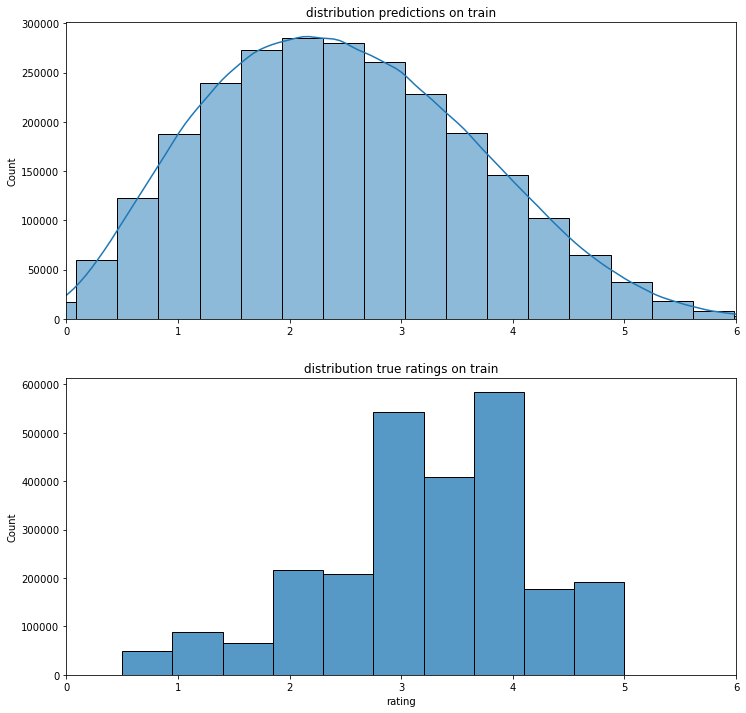

In [68]:
fig, axs = plt.subplots(2,1, figsize=(12,12))

sns.histplot(train_predictions, bins=30, kde=True, ax=axs[0])
axs[0].set_title("distribution predictions on train")
axs[0].set(xlim=(0, 6))

sns.histplot(data_train['rating'], bins=10, kde=False, ax=axs[1])
axs[1].set_title("distribution true ratings on train")
axs[1].set(xlim=(0, 6))

### This last graph illustrates why it seems relevant to center data : the mean of the predicted ratings is clearly lower than the mean of the true ratings.

### Let's now train the model on the whole dataset and export it.

In [78]:
%%time
svd_data_not_centered = TruncatedSVD(n_components=200, n_iter=1000, random_state=0)
svd_data_not_centered.fit(data_1000_csr)

CPU times: user 44min 19s, sys: 8min, total: 52min 19s
Wall time: 6min 45s


TruncatedSVD(n_components=200, n_iter=1000, random_state=0)

In [79]:
pickle.dump(svd_data_not_centered, open('svd_data_not_centered_v2.sav','wb'))